# Creating a GAN to Generate Art Styled After Yoshitaka Amano

## Ryan Richardson
## CS 770 - Deep Learning




### Task

The task I choose to pursue was the generation of images in the style of Yoshitaka Amano using deep learning. Various deep learning models can be employed for this task, each with its own strengths and performance characteristics. The category of models I chose to pursue was Generative Adversarial Networks (GANs), which are widely used.  Specifically I would compare a normal GAN to a StyleGan for image generation. I would also attempted to augment my networks with an Augmented Discriminator in an attempt to compensate for a low amount of training data. When comparing the performance of these models, factors such as image quality, diversity, realism, and control over attributes need to be considered.

An ADA (Augmented Data Augmentation) technique can be used to augment small training sets for a Generative Adversarial Network (GAN). When the available training data is limited, ADA provides a way to artificially increase the dataset size and improve the training process. ADA achieves this by applying various data augmentation techniques to the existing training samples, creating additional synthetic data points. These augmentation techniques can include transformations such as rotations, translations, scaling, flipping, and adding random noise. By introducing these augmented samples during training, the GAN learns from a more diverse and varied set of data, helping to improve its generalization and ability to generate realistic and diverse images. ADA is particularly useful when the original training set is small, as it helps mitigate overfitting and improves the model's robustness by providing a broader range of training examples.

### Dataset

The data set consists of scanned images of Yoshitaka Amano's art as well as images obtained through web scraping from online sources that feature his artwork. Yoshitaka Amano is a renowned Japanese artist known for his distinctive style, particularly his illustrations for various media, including manga, anime, and video games. The scanned images in the data set are obtained from physical copies of Amano's books, ensuring a high-quality representations of his original creations. Additionally, images scraped from online sources provide a broader collection. Despite this, I was only able to build a training set of ~1800 images, which necessitated the use of augmentation.

### Model Performance

To achieve the results, both a GAN and a StyleGAN were trained on a small dataset, with the GAN performing worse than the StyleGAN. To improve their performance, an ADA (Augmented Data Augmentation) technique was employed, which artificially expanded the dataset by applying various data augmentation techniques. Different hyperparameters were tuned for both models, including learning rate, batch size, and network architecture, in an attempt to enhance their performance. Additionally, different augmentations were explored within the ADA, such as rotations, translations, scaling, flipping, and adding random noise. The models were also trained on different image sizes to evaluate their impact on the generated results. However, due to excessive training times, there was a limit on the number of variations that could be tried.

Despite the limitations, the StyleGAN exhibited superior performance compared to the GAN. Some images generated by the StyleGAN successfully emulated the line work and color details of the target artist. This suggests that the StyleGAN's architecture, which incorporates style-based techniques and provides fine-grained control over image attributes, better captured the nuances of the artist's style. Although the GAN's performance was subpar, the attempts at hyperparameter tuning and augmentations through ADA helped mitigate the limitations of the small dataset, providing some improvements. However, the training times and the limited number of variations that could be explored posed challenges in fully optimizing the models' performance.

### Conlusion + Future Improvements

In conclusion, when working with a small dataset, the StyleGAN outperformed the GAN in generating images that closely resembled the target artist's line work and color detail. The application of ADA and the exploration of different hyperparameters and augmentations helped enhance the models' performance, albeit with limitations due to training times and the number of variations that could be tested. Despite these challenges, the StyleGAN demonstrated its effectiveness in capturing the artist's style.

To further improve the method, several enhancements can be considered. Firstly, transfer learning can be utilized by pretraining the models on larger image collections that exhibit similar artistic styles. This approach leverages the knowledge learned from these larger datasets to bootstrap the training process on the small dataset, potentially leading to better results. Additionally, acquiring a more comprehensive and diverse image collection specifically curated for the target artist could provide richer training data, leading to improved performance.

Automated hyperparameter tuning techniques, such as Bayesian optimization or evolutionary algorithms, can be employed to efficiently search for optimal hyperparameter configurations. This approach can save significant time and effort by automatically exploring a wide range of hyperparameter settings to find the best combination for the models.

Moreover, by utilizing multiple workstations or distributed computing resources, the models can be trained in parallel, allowing for quicker experimentation and evaluation of different variations. This approach reduces the overall training time and enables testing a larger number of hyperparameter combinations, augmentations, and architectural variations, leading to more comprehensive and refined models.

In summary, improvements to the method include transfer learning, better image collections, automated hyperparameter tuning, and parallel training using multiple workstations. These enhancements have the potential to further enhance the performance of the models in generating artwork that closely resembles the desired style and details of the target artist.


In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.transforms import InterpolationMode

## Using GAN To Generate Images

In [ ]:
dataroot = "data"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 500
lr = 0.0002
beta1 = 0.5
ngpu = 1

## Load Training Set and Create DataLoader

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.RandomResizedCrop(image_size, scale=(0.9, 1.1), ratio=(0.9, 1.1), interpolation=InterpolationMode.BICUBIC),
                               transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               transforms.CenterCrop(image_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandAugment(),
                               transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Define the Generator and Discriminator

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Style GAN

In [2]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow_addons.layers import InstanceNormalization

import gdown
from zipfile import ZipFile


C:\Users\Ryan\.conda\envs\PhD\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def log2(x):
    return int(np.log2(x))


# we use different batch size for different resolution, so larger image size
# could fit into GPU memory. The keys is image resolution in log2
batch_sizes = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10: 1}
# We adjust the train step accordingly
train_step_ratio = {k: batch_sizes[2] / v for k, v in batch_sizes.items()}

# Create a dataset from our folder, and rescale the images to the [0-1] range:

ds_train = keras.utils.image_dataset_from_directory(
    "data/training", label_mode=None, image_size=(64, 64), batch_size=32
)
ds_train = ds_train.map(lambda x: x / 255.0)


def resize_image(res, image):
    # only donwsampling, so use nearest neighbor that is faster to run
    image = tf.image.resize(
        image, (res, res), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image


def create_dataloader(res):
    batch_size = batch_sizes[log2(res)]
    # NOTE: we unbatch the dataset so we can `batch()` it again with the `drop_remainder=True` option
    # since the model only supports a single batch size
    dl = ds_train.map(partial(resize_image, res), num_parallel_calls=tf.data.AUTOTUNE).unbatch()
    dl = dl.shuffle(200).batch(batch_size, drop_remainder=True).prefetch(1).repeat()
    return dl


Found 1848 files belonging to 1 classes.


In [4]:
def plot_images(images, log2_res, fname=""):
    scales = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    scale = scales[log2_res]

    grid_col = min(images.shape[0], int(32 // scale))
    grid_row = 1

    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(grid_col * scale, grid_row * scale)
    )

    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row * grid_col + col])
            ax[col].axis("off")
    plt.show()
    if fname:
        f.savefig(fname)


## Creating Custom Layers and Transformations

In [5]:
def fade_in(alpha, a, b):
    return alpha * a + (1.0 - alpha) * b


def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)


def pixel_norm(x, epsilon=1e-8):
    return x / tf.math.sqrt(tf.reduce_mean(x ** 2, axis=-1, keepdims=True) + epsilon)


def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c])
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False)
    group_std = tf.sqrt(group_var + epsilon)
    avg_std = tf.reduce_mean(group_std, axis=[1, 2, 3], keepdims=True)
    x = tf.tile(avg_std, [group_size, h, w, 1])
    return tf.concat([input_tensor, x], axis=-1)


class EqualizedConv(layers.Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel != 1

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.w = self.add_weight(
            shape=[self.kernel, self.kernel, self.in_channels, self.out_channels],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.out_channels,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.kernel * self.kernel * self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
        else:
            x = inputs
        output = (
            tf.nn.conv2d(x, self.scale * self.w, strides=1, padding="VALID") + self.b
        )
        return output


class EqualizedDense(layers.Layer):
    def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.gain = gain
        self.learning_rate_multiplier = learning_rate_multiplier

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(
            mean=0.0, stddev=1.0 / self.learning_rate_multiplier
        )
        self.w = self.add_weight(
            shape=[self.in_channels, self.units],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale * self.w), self.b)
        return output * self.learning_rate_multiplier


class AddNoise(layers.Layer):
    def build(self, input_shape):
        n, h, w, c = input_shape[0]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.b = self.add_weight(
            shape=[1, 1, 1, c], initializer=initializer, trainable=True, name="kernel"
        )

    def call(self, inputs):
        x, noise = inputs
        output = x + self.b * noise
        return output


class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super().__init__(**kwargs)
        self.gain = gain

    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]

        self.dense_1 = EqualizedDense(self.x_channels, gain=1)
        self.dense_2 = EqualizedDense(self.x_channels, gain=1)

    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        return ys * x + yb


Create the Generator, Discriminator, and a Noise Map Model

In [6]:
def Mapping(num_stages, input_shape=512):
    z = layers.Input(shape=(input_shape))
    w = pixel_norm(z)
    for i in range(8):
        w = EqualizedDense(512, learning_rate_multiplier=0.01)(w)
        w = layers.LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1, num_stages, 1))
    return keras.Model(z, w, name="mapping")


class Generator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # list of generator blocks at increasing resolution
        self.g_blocks = []
        # list of layers to convert g_block activation to RGB
        self.to_rgb = []
        # list of noise input of different resolutions into g_blocks
        self.noise_inputs = []
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024

        start_res = 2 ** start_res_log2
        self.input_shape = (start_res, start_res, self.filter_nums[start_res_log2])
        self.g_input = layers.Input(self.input_shape, name="generator_input")

        for i in range(start_res_log2, target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2 ** i
            self.noise_inputs.append(
                layers.Input(shape=(res, res, 1), name=f"noise_{res}x{res}")
            )
            to_rgb = Sequential(
                [
                    layers.InputLayer(input_shape=(res, res, filter_num)),
                    EqualizedConv(3, 1, gain=1),
                ],
                name=f"to_rgb_{res}x{res}",
            )
            self.to_rgb.append(to_rgb)
            is_base = i == self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i - 1])
            else:
                input_shape = (2 ** (i - 1), 2 ** (i - 1), self.filter_nums[i - 1])
            g_block = self.build_block(
                filter_num, res=res, input_shape=input_shape, is_base=is_base
            )
            self.g_blocks.append(g_block)

    def build_block(self, filter_num, res, input_shape, is_base):
        input_tensor = layers.Input(shape=input_shape, name=f"g_{res}")
        noise = layers.Input(shape=(res, res, 1), name=f"noise_{res}")
        w = layers.Input(shape=512)
        x = input_tensor

        if not is_base:
            x = layers.UpSampling2D((2, 2))(x)
            x = EqualizedConv(filter_num, 3)(x)

        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])

        x = EqualizedConv(filter_num, 3)(x)
        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        return keras.Model([input_tensor, w, noise], x, name=f"genblock_{res}x{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2

        num_stages = res_log2 - self.start_res_log2 + 1
        w = layers.Input(shape=(self.num_stages, 512), name="w")

        alpha = layers.Input(shape=(1), name="g_alpha")
        x = self.g_blocks[0]([self.g_input, w[:, 0], self.noise_inputs[0]])

        if num_stages == 1:
            rgb = self.to_rgb[0](x)
        else:
            for i in range(1, num_stages - 1):

                x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            old_rgb = self.to_rgb[num_stages - 2](x)
            old_rgb = layers.UpSampling2D((2, 2))(old_rgb)

            i = num_stages - 1
            x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(alpha[0], new_rgb, old_rgb)

        return keras.Model(
            [self.g_input, w, self.noise_inputs, alpha],
            rgb,
            name=f"generator_{res}_x_{res}",
        )


class Discriminator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024
        # list of discriminator blocks at increasing resolution
        self.d_blocks = []
        # list of layers to convert RGB into activation for d_blocks inputs
        self.from_rgb = []

        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2 ** res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential(
                [
                    layers.InputLayer(
                        input_shape=(res, res, 3), name=f"from_rgb_input_{res}"
                    ),
                    EqualizedConv(filter_num, 1),
                    layers.LeakyReLU(0.2),
                ],
                name=f"from_rgb_{res}",
            )

            self.from_rgb.append(from_rgb)

            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:
                d_block = self.build_base(filter_num, res)
            else:
                d_block = self.build_block(
                    filter_num, self.filter_nums[res_log2 - 1], res
                )

            self.d_blocks.append(d_block)

    def build_base(self, filter_num, res):
        input_tensor = layers.Input(shape=(res, res, filter_num), name=f"d_{res}")
        x = minibatch_std(input_tensor)
        x = EqualizedConv(filter_num, 3)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Flatten()(x)
        x = EqualizedDense(filter_num)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedDense(1)(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def build_block(self, filter_num_1, filter_num_2, res):
        input_tensor = layers.Input(shape=(res, res, filter_num_1), name=f"d_{res}")
        x = EqualizedConv(filter_num_1, 3)(input_tensor)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedConv(filter_num_2)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.AveragePooling2D((2, 2))(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2
        idx = res_log2 - self.start_res_log2
        alpha = layers.Input(shape=(1), name="d_alpha")
        input_image = layers.Input(shape=(res, res, 3), name="input_image")
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)
        if idx > 0:
            idx -= 1
            downsized_image = layers.AveragePooling2D((2, 2))(input_image)
            y = self.from_rgb[idx](downsized_image)
            x = fade_in(alpha[0], x, y)

            for i in range(idx, -1, -1):
                x = self.d_blocks[i](x)
        return keras.Model([input_image, alpha], x, name=f"discriminator_{res}_x_{res}")


In [7]:
class StyleGAN(tf.keras.Model):
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super().__init__()
        self.z_dim = z_dim

        self.target_res_log2 = log2(target_res)
        self.start_res_log2 = log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

        self.alpha = tf.Variable(1.0, dtype=tf.float32, trainable=False, name="alpha")

        self.mapping = Mapping(num_stages=self.num_stages)
        self.d_builder = Discriminator(self.start_res_log2, self.target_res_log2)
        self.g_builder = Generator(self.start_res_log2, self.target_res_log2)
        self.g_input_shape = self.g_builder.input_shape

        self.phase = None
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)

        self.loss_weights = {"gradient_penalty": 10, "drift": 0.001}

    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = log2(res)
        self.generator = self.g_builder.grow(res_log2)
        self.discriminator = self.d_builder.grow(res_log2)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")

    def compile(
        self, steps_per_epoch, phase, res, d_optimizer, g_optimizer, *args, **kwargs
    ):
        self.loss_weights = kwargs.pop("loss_weights", self.loss_weights)
        self.steps_per_epoch = steps_per_epoch
        if res != 2 ** self.current_res_log2:
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer

        self.train_step_counter.assign(0)
        self.phase = phase
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        super().compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def generate_noise(self, batch_size):
        noise = [
            tf.random.normal((batch_size, 2 ** res, 2 ** res, 1))
            for res in range(self.start_res_log2, self.target_res_log2 + 1)
        ]
        return noise

    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=tf.range(1, tf.size(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss

    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)

        if self.phase == "TRANSITION":
            self.alpha.assign(
                tf.cast(self.train_step_counter / self.steps_per_epoch, tf.float32)
            )
        elif self.phase == "STABLE":
            self.alpha.assign(1.0)
        else:
            raise NotImplementedError
        alpha = tf.expand_dims(self.alpha, 0)
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)
            fake_images = self.generator([const_input, w, noise, alpha])
            pred_fake = self.discriminator([fake_images, alpha])
            g_loss = wasserstein_loss(real_labels, pred_fake)

            trainable_weights = (
                self.mapping.trainable_weights + self.generator.trainable_weights
            )
            gradients = g_tape.gradient(g_loss, trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradients, trainable_weights))

        # discriminator
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])

            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon * real_images + (1 - epsilon) * fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])

            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)

            # gradient penalty
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights[
                "gradient_penalty"
            ] * self.gradient_loss(gradients_fake)

            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights["drift"] * tf.reduce_mean(all_pred ** 2)

            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradients = total_tape.gradient(
                d_loss, self.discriminator.trainable_weights
            )
            self.d_optimizer.apply_gradients(
                zip(gradients, self.discriminator.trainable_weights)
            )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs: dict()):
        style_code = inputs.get("style_code", None)
        z = inputs.get("z", None)
        noise = inputs.get("noise", None)
        batch_size = inputs.get("batch_size", 1)
        alpha = inputs.get("alpha", 1.0)
        alpha = tf.expand_dims(alpha, 0)
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))
            style_code = self.mapping(z)

        if noise is None:
            noise = self.generate_noise(batch_size)

        # self.alpha.assign(alpha)

        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        images = self.generator([const_input, style_code, noise, alpha])
        images = np.clip((images * 0.5 + 0.5) * 255, 0, 255).astype(np.uint8)

        return images


In [8]:
START_RES = 4
TARGET_RES = 128

style_gan = StyleGAN(start_res=START_RES, target_res=TARGET_RES)


In [9]:
def train(
    start_res=START_RES,
    target_res=TARGET_RES,
    steps_per_epoch=5000,
    display_images=True,
):
    opt_cfg = {"learning_rate": 1e-3, "beta_1": 0.0, "beta_2": 0.99, "epsilon": 1e-8}

    val_batch_size = 16
    val_z = tf.random.normal((val_batch_size, style_gan.z_dim))
    val_noise = style_gan.generate_noise(val_batch_size)

    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    for res_log2 in range(start_res_log2, target_res_log2 + 1):
        res = 2 ** res_log2
        for phase in ["TRANSITION", "STABLE"]:
            if res == start_res and phase == "TRANSITION":
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            style_gan.compile(
                d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                g_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                loss_weights={"gradient_penalty": 10, "drift": 0.001},
                steps_per_epoch=steps,
                res=res,
                phase=phase,
                run_eagerly=False,
            )

            prefix = f"res_{res}x{res}_{style_gan.phase}"

            ckpt_cb = keras.callbacks.ModelCheckpoint(
                f"checkpoints/stylegan_{res}x{res}.ckpt",
                save_weights_only=True,
                verbose=0,
            )
            print(phase)
            style_gan.fit(
                train_dl, epochs=10, steps_per_epoch=steps, callbacks=[ckpt_cb]
            )

            if display_images:
                images = style_gan({"z": val_z, "noise": val_noise, "alpha": 1.0})
                plot_images(images, res_log2)



Model resolution:4x4
STABLE
Epoch 1/10
50/50 [==============================] - 28s 388ms/step - d_loss: -11.5285 - g_loss: 13.1956
Epoch 2/10
50/50 [==============================] - 18s 368ms/step - d_loss: -18.8498 - g_loss: 25.7006
Epoch 3/10
50/50 [==============================] - 19s 379ms/step - d_loss: -15.4876 - g_loss: 19.8864
Epoch 4/10
50/50 [==============================] - 20s 406ms/step - d_loss: -13.7689 - g_loss: 16.4153
Epoch 5/10
50/50 [==============================] - 19s 391ms/step - d_loss: -12.6907 - g_loss: 14.6019
Epoch 6/10
50/50 [==============================] - 19s 388ms/step - d_loss: -11.2729 - g_loss: 11.5685
Epoch 7/10
50/50 [==============================] - 20s 392ms/step - d_loss: -10.4659 - g_loss: 9.9942
Epoch 8/10
50/50 [==============================] - 19s 384ms/step - d_loss: -9.7114 - g_loss: 8.7150
Epoch 9/10
50/50 [==============================] - 19s 371ms/step - d_loss: -9.0727 - g_loss: 7.6350
Epoch 10/10
50/50 [=====================

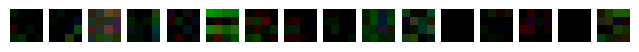


Model resolution:8x8
TRANSITION
Epoch 1/10
50/50 [==============================] - 92s 2s/step - d_loss: -26.9786 - g_loss: 31.8301
Epoch 2/10
50/50 [==============================] - 79s 2s/step - d_loss: -84.9771 - g_loss: 127.2402
Epoch 3/10
50/50 [==============================] - 73s 1s/step - d_loss: -144.4530 - g_loss: 219.9134
Epoch 4/10
50/50 [==============================] - 72s 1s/step - d_loss: -199.3820 - g_loss: 289.2416
Epoch 5/10
50/50 [==============================] - 67s 1s/step - d_loss: -249.4110 - g_loss: 324.0295
Epoch 6/10
50/50 [==============================] - 67s 1s/step - d_loss: -299.8996 - g_loss: 348.5994
Epoch 7/10
50/50 [==============================] - 70s 1s/step - d_loss: -320.6091 - g_loss: 358.3722
Epoch 8/10
50/50 [==============================] - 66s 1s/step - d_loss: -375.3089 - g_loss: 392.8474
Epoch 9/10
50/50 [==============================] - 67s 1s/step - d_loss: -380.9714 - g_loss: 395.1752
Epoch 10/10
50/50 [========================

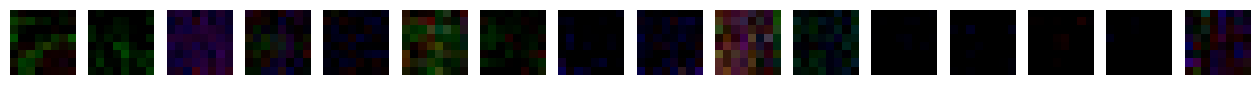

STABLE
Epoch 1/10
50/50 [==============================] - 70s 1s/step - d_loss: -6.9557 - g_loss: -10.5621
Epoch 2/10
50/50 [==============================] - 64s 1s/step - d_loss: -5.9798 - g_loss: -12.8691
Epoch 3/10
50/50 [==============================] - 66s 1s/step - d_loss: -12.7044 - g_loss: -38.4840
Epoch 4/10
50/50 [==============================] - 65s 1s/step - d_loss: -14.0373 - g_loss: -25.6009
Epoch 5/10
50/50 [==============================] - 68s 1s/step - d_loss: -14.8631 - g_loss: -13.5004
Epoch 6/10
50/50 [==============================] - 65s 1s/step - d_loss: -15.1798 - g_loss: -4.5244
Epoch 7/10
50/50 [==============================] - 65s 1s/step - d_loss: -15.2265 - g_loss: 2.1457
Epoch 8/10
50/50 [==============================] - 68s 1s/step - d_loss: -15.5423 - g_loss: 7.8866
Epoch 9/10
50/50 [==============================] - 68s 1s/step - d_loss: -14.8052 - g_loss: 8.8603
Epoch 10/10
50/50 [==============================] - 68s 1s/step - d_loss: -14.4775 

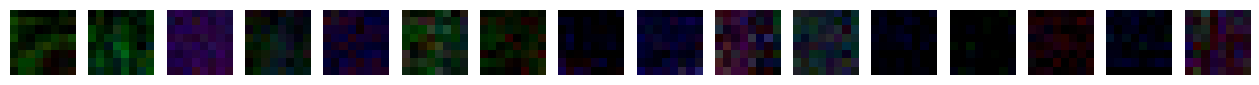


Model resolution:16x16
TRANSITION
Epoch 1/10
50/50 [==============================] - 202s 4s/step - d_loss: -52.1391 - g_loss: 62.9558
Epoch 2/10
50/50 [==============================] - 194s 4s/step - d_loss: -162.1219 - g_loss: 215.2265
Epoch 3/10
50/50 [==============================] - 187s 4s/step - d_loss: -247.9900 - g_loss: 370.0863
Epoch 4/10
50/50 [==============================] - 184s 4s/step - d_loss: -245.2619 - g_loss: 473.7762
Epoch 5/10
41/50 [=======================>......] - ETA: 32s - d_loss: -391.1985 - g_loss: 530.3760

In [ ]:
train(start_res=4, target_res=256, steps_per_epoch=50, display_images=True)

In [ ]:
url = "https://github.com/soon-yau/stylegan_keras/releases/download/keras_example_v1.0/stylegan_128x128.ckpt.zip"

weights_path = keras.utils.get_file(
    "stylegan_128x128.ckpt.zip",
    url,
    extract=True,
    cache_dir=os.path.abspath("."),
    cache_subdir="pretrained",
)

style_gan.grow_model(256)
style_gan.load_weights(os.path.join("pretrained/stylegan_128x128.ckpt"))

tf.random.set_seed(196)
batch_size = 2
z = tf.random.normal((batch_size, style_gan.z_dim))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size=batch_size)
images = style_gan({"style_code": w, "noise": noise, "alpha": 1.0})
plot_images(images, 5)
